In [24]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error

In [25]:
import time

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [27]:
# Cell 2: Dataset Classes
class UnlabelledDataset(Dataset):
    def __init__(self, h5_path, transform=None):
        self.h5_file = h5py.File(h5_path, 'r')
        self.data = self.h5_file['jet']
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = np.array(self.data[idx], dtype=np.float32).transpose(2, 0, 1)  # (8, 125, 125)
        if self.transform:
            return self.transform(image), self.transform(image)
        return torch.from_numpy(image).float()

class LabelledDataset(Dataset):
    def __init__(self, h5_path, transform=None):
        self.h5_file = h5py.File(h5_path, 'r')
        self.images = self.h5_file['jet']
        self.labels = self.h5_file['Y']
        self.targets = self.h5_file['m']
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.array(self.images[idx], dtype=np.float32).transpose(2, 0, 1)
        label = int(self.labels[idx][0])
        target = float(self.targets[idx][0])
        if self.transform:
            image = self.transform(image)
        return image, label, target

In [28]:
# Cell 3: Data Preprocessing
# Compute normalization stats
unlabelled_dataset = UnlabelledDataset('../Dataset_Specific_Unlabelled.h5')
loader = DataLoader(unlabelled_dataset, batch_size=64)
mean = torch.zeros(8)
std = torch.zeros(8)
for images in tqdm(loader):
    images = images if isinstance(images, torch.Tensor) else images[0]
    images = images.view(images.size(0), 8, -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
mean /= len(unlabelled_dataset)
std /= len(unlabelled_dataset)

100%|██████████| 938/938 [00:24<00:00, 38.60it/s]


In [29]:
import torch
import torch.nn.functional as F
from torchvision import transforms

class ToTensor:
    """Converting numpy array to tensor without normalization"""
    def __call__(self, img):
        return torch.as_tensor(img, dtype=torch.float32)

class RandomResizedCropTensor:
    """Tensor version of RandomResizedCrop"""
    def __init__(self, size, scale=(0.2, 1.0)):
        self.size = size
        self.scale = scale
        
    def __call__(self, img):
        _, h, w = img.shape
        new_h = int(h * torch.empty(1).uniform_(self.scale[0], self.scale[1]).item())
        new_w = int(w * torch.empty(1).uniform_(self.scale[0], self.scale[1]).item())
        i = torch.randint(0, h - new_h + 1, (1,)).item()
        j = torch.randint(0, w - new_w + 1, (1,)).item()
        img = img[:, i:i+new_h, j:j+new_w]
        return F.interpolate(img.unsqueeze(0), size=(self.size, self.size), 
                          mode='bilinear', align_corners=False).squeeze(0)

class ResizeTensor:
    """Custom resize for tensor inputs"""
    def __init__(self, size):
        self.size = size
        
    def __call__(self, img):
        return F.interpolate(img.unsqueeze(0), 
                           size=(self.size, self.size), 
                           mode='bilinear',
                           align_corners=False).squeeze(0)

class Normalize:
    """Normalization for tensor inputs"""
    def __init__(self, mean, std):
        self.mean = mean.view(8, 1, 1)
        self.std = std.view(8, 1, 1)
        
    def __call__(self, img):
        return (img - self.mean) / self.std

ssl_transform = transforms.Compose([
    ToTensor(),
    RandomResizedCropTensor(224),
    transforms.RandomHorizontalFlip(),
    Normalize(mean, std)
])

ft_transform = transforms.Compose([
    ToTensor(),
    ResizeTensor(224),
    Normalize(mean, std)
])

In [30]:
# Model Architecture
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet15(nn.Module):
    def __init__(self, in_channels=8):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(BasicBlock, 64, 2)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 1, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 1, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

class BarlowTwins(nn.Module):
    def __init__(self, backbone, projector_dims):
        super().__init__()
        self.backbone = backbone
        self.projector = nn.Sequential(
            nn.Linear(512, projector_dims[0]),
            nn.BatchNorm1d(projector_dims[0]),
            nn.ReLU(),
            nn.Linear(projector_dims[0], projector_dims[1]),
        )

    def forward(self, x):
        z = self.backbone(x)
        return self.projector(z)
    
    @staticmethod
    def barlow_loss(z_a, z_b, lambda_param=5e-3):
        N, D = z_a.size(0), z_a.size(1)
        z_a = (z_a - z_a.mean(0)) / (z_a.std(0) + 1e-8)
        z_b = (z_b - z_b.mean(0)) / (z_b.std(0) + 1e-8)
        c = torch.mm(z_a.T, z_b) / N
        loss = (1 - c.diag()).pow(2).sum() + lambda_param * (c.triu(1).pow(2).sum() + c.tril(-1).pow(2).sum())
        return loss

In [31]:
# SSL Pretraining
def train_ssl(model, loader, epochs=100):
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    train_losses = []
    best_loss = float('inf')
    patience = 5
    no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x1, x2 in tqdm(loader, desc=f"SSL Epoch {epoch+1}"):
            x1, x2 = x1.float().to(device), x2.float().to(device)
            
            # Forward pass
            z1 = model(x1)
            z2 = model(x2)
            
            loss = BarlowTwins.barlow_loss(z1, z2)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss/len(loader)
        train_losses.append(avg_loss)
        
        # Early stopping check
        if avg_loss < best_loss - 0.001:
            best_loss = avg_loss
            no_improve = 0
            torch.save(model.backbone.state_dict(), './best_ssl.pth')
            print(f"New best loss: {best_loss:.4f}")
        else:
            no_improve += 1
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Patience: {no_improve}/{patience}')
        
        if no_improve >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
            
    # Plot training curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='SSL Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Barlow Twins Training Progress')
    plt.legend()
    plt.grid(True)
    plt.savefig('./ssl_training_curve.png')
    plt.show()
    
    return model

In [32]:
# Fine-tuning Setup
def create_ft_model(pretrained=True):
    backbone = ResNet15()
    if pretrained:
        backbone.load_state_dict(torch.load('./best_ssl.pth'))
    return FineTuneModel(backbone, num_classes=len(classes)).to(device)

In [33]:
def train_ft(model, train_loader, val_loader, epochs=50):
    # 1. Enhanced optimizer with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    
    # 2. Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=3e-4,
        steps_per_epoch=len(train_loader),
        epochs=epochs,
        pct_start=0.3
    )
    
    # 3. Loss tracking
    train_losses, val_losses = [], []
    best_loss = float('inf')
    patience = 5
    no_improve = 0
    criterion_cls = nn.CrossEntropyLoss()
    criterion_reg = nn.SmoothL1Loss()
    
    # 4. Mixed precision and gradient scaling
    scaler = torch.cuda.amp.GradScaler()
    
    print(f"\n{'Epoch':<6} | {'Train Loss':<10} | {'Val Loss':<10} | {'Improv%':<8} | {'Status':<12} | {'LR':<10}")
    print("-"*70)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for x, y, t in tqdm(train_loader, desc=f"FT Epoch {epoch+1}", leave=False):
            x, y, t = x.to(device), y.to(device), t.to(device)
            
            with torch.cuda.amp.autocast():
                logits, preds = model(x)
                loss = 0.7*criterion_cls(logits, y) + 0.3*criterion_reg(preds.squeeze(), t)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
            
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y, t in val_loader:
                x, y, t = x.to(device), y.to(device), t.to(device)
                logits, preds = model(x)
                val_loss += (0.7*criterion_cls(logits, y) + 0.3*criterion_reg(preds.squeeze(), t)).item()

        # Calculate metrics
        avg_train = train_loss/len(train_loader)
        avg_val = val_loss/len(val_loader)
        improvement = (best_loss - avg_val)/abs(best_loss) if best_loss != float('inf') else float('inf')
        
        # Early stopping
        if improvement > 0.01:  # 1% relative improvement
            best_loss = avg_val
            no_improve = 0
            status = "✔ Improved"
            torch.save(model.state_dict(), './best_ft.pth')
        else:
            no_improve += 1
            status = f"✖ ({no_improve}/{patience})"
        
        # Store losses
        train_losses.append(avg_train)
        val_losses.append(avg_val)
        
        # Print progress
        print(f"{epoch+1:03d}/{epochs:03d} | {avg_train:<10.2f} | {avg_val:<10.2f} | "
              f"{improvement*100:>+6.1f}% | {status:<12} | {optimizer.param_groups[0]['lr']:.1e}")

        if no_improve >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    # Save final plot
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Fine-tuning Loss Progress')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./ft_final_progress.png')
    plt.close()
    
    return model

In [34]:
# Cell 9: Evaluation
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels, all_targets = [], [], []
    
    with torch.no_grad():
        for x, y, t in loader:
            x = x.float().to(device)
            logits, preds = model(x)
            
            all_preds.extend(logits.argmax(1).cpu().numpy())
            all_labels.extend(y.numpy())
            all_targets.extend(t.numpy())
            all_reg_preds.extend(preds.squeeze().cpu().numpy())
    
    # Classification metrics
    cm = confusion_matrix(all_labels, all_preds)
    acc = np.mean(np.array(all_labels) == np.array(all_preds))
    
    # Regression metrics
    rmse = np.sqrt(mean_squared_error(all_targets, all_reg_preds))
    
    # Plotting
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    
    plt.subplot(1,2,2)
    plt.scatter(all_targets, all_reg_preds, alpha=0.3)
    plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'Regression Results (RMSE: {rmse:.4f})')
    
    plt.tight_layout()
    plt.savefig('./evaluation.png')
    plt.show()
    
    return acc, rmse

In [35]:
# SSL Pretraining
ssl_dataset = UnlabelledDataset('../Dataset_Specific_Unlabelled.h5', ssl_transform)
# Cell 7: SSL Pretraining
ssl_loader = DataLoader(
    UnlabelledDataset('../Dataset_Specific_Unlabelled.h5', transform=ssl_transform),
    batch_size=256,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True
)

ssl_model = BarlowTwins(ResNet15(), [2048,2048]).to(device)

SSL Epoch 1: 100%|██████████| 235/235 [01:47<00:00,  2.18it/s]


New best loss: 861.0040
Epoch 1/50, Loss: 861.0040, Patience: 0/5


SSL Epoch 2: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


New best loss: 439.3790
Epoch 2/50, Loss: 439.3790, Patience: 0/5


SSL Epoch 3: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


New best loss: 357.8328
Epoch 3/50, Loss: 357.8328, Patience: 0/5


SSL Epoch 4: 100%|██████████| 235/235 [01:43<00:00,  2.27it/s]


New best loss: 325.9533
Epoch 4/50, Loss: 325.9533, Patience: 0/5


SSL Epoch 5: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


New best loss: 306.0486
Epoch 5/50, Loss: 306.0486, Patience: 0/5


SSL Epoch 6: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


New best loss: 293.2589
Epoch 6/50, Loss: 293.2589, Patience: 0/5


SSL Epoch 7: 100%|██████████| 235/235 [01:43<00:00,  2.27it/s]


New best loss: 282.2971
Epoch 7/50, Loss: 282.2971, Patience: 0/5


SSL Epoch 8: 100%|██████████| 235/235 [01:43<00:00,  2.28it/s]


New best loss: 274.3541
Epoch 8/50, Loss: 274.3541, Patience: 0/5


SSL Epoch 9: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


New best loss: 267.8943
Epoch 9/50, Loss: 267.8943, Patience: 0/5


SSL Epoch 10: 100%|██████████| 235/235 [01:43<00:00,  2.27it/s]


New best loss: 262.5391
Epoch 10/50, Loss: 262.5391, Patience: 0/5


SSL Epoch 11: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


New best loss: 255.7866
Epoch 11/50, Loss: 255.7866, Patience: 0/5


SSL Epoch 12: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


New best loss: 250.6190
Epoch 12/50, Loss: 250.6190, Patience: 0/5


SSL Epoch 13: 100%|██████████| 235/235 [01:43<00:00,  2.28it/s]


New best loss: 247.9620
Epoch 13/50, Loss: 247.9620, Patience: 0/5


SSL Epoch 14: 100%|██████████| 235/235 [01:43<00:00,  2.26it/s]


New best loss: 244.8113
Epoch 14/50, Loss: 244.8113, Patience: 0/5


SSL Epoch 15: 100%|██████████| 235/235 [01:43<00:00,  2.26it/s]


New best loss: 241.4101
Epoch 15/50, Loss: 241.4101, Patience: 0/5


SSL Epoch 16: 100%|██████████| 235/235 [01:44<00:00,  2.26it/s]


New best loss: 238.0972
Epoch 16/50, Loss: 238.0972, Patience: 0/5


SSL Epoch 17: 100%|██████████| 235/235 [01:44<00:00,  2.25it/s]


New best loss: 234.9734
Epoch 17/50, Loss: 234.9734, Patience: 0/5


SSL Epoch 18: 100%|██████████| 235/235 [01:43<00:00,  2.27it/s]


New best loss: 232.5920
Epoch 18/50, Loss: 232.5920, Patience: 0/5


SSL Epoch 19: 100%|██████████| 235/235 [01:44<00:00,  2.25it/s]


New best loss: 229.8900
Epoch 19/50, Loss: 229.8900, Patience: 0/5


SSL Epoch 20: 100%|██████████| 235/235 [01:44<00:00,  2.25it/s]


New best loss: 226.1675
Epoch 20/50, Loss: 226.1675, Patience: 0/5


SSL Epoch 21: 100%|██████████| 235/235 [01:45<00:00,  2.23it/s]


New best loss: 226.0112
Epoch 21/50, Loss: 226.0112, Patience: 0/5


SSL Epoch 22: 100%|██████████| 235/235 [01:44<00:00,  2.25it/s]


New best loss: 224.7048
Epoch 22/50, Loss: 224.7048, Patience: 0/5


SSL Epoch 23: 100%|██████████| 235/235 [01:44<00:00,  2.25it/s]


New best loss: 222.1994
Epoch 23/50, Loss: 222.1994, Patience: 0/5


SSL Epoch 24: 100%|██████████| 235/235 [01:43<00:00,  2.26it/s]


New best loss: 219.4859
Epoch 24/50, Loss: 219.4859, Patience: 0/5


SSL Epoch 25: 100%|██████████| 235/235 [01:44<00:00,  2.25it/s]


New best loss: 217.8856
Epoch 25/50, Loss: 217.8856, Patience: 0/5


SSL Epoch 26: 100%|██████████| 235/235 [01:44<00:00,  2.26it/s]


New best loss: 216.9247
Epoch 26/50, Loss: 216.9247, Patience: 0/5


SSL Epoch 27: 100%|██████████| 235/235 [01:44<00:00,  2.25it/s]


New best loss: 215.7010
Epoch 27/50, Loss: 215.7010, Patience: 0/5


SSL Epoch 28: 100%|██████████| 235/235 [01:44<00:00,  2.25it/s]


New best loss: 214.3821
Epoch 28/50, Loss: 214.3821, Patience: 0/5


SSL Epoch 29: 100%|██████████| 235/235 [01:44<00:00,  2.24it/s]


New best loss: 212.3618
Epoch 29/50, Loss: 212.3618, Patience: 0/5


SSL Epoch 30: 100%|██████████| 235/235 [01:44<00:00,  2.24it/s]


New best loss: 210.1358
Epoch 30/50, Loss: 210.1358, Patience: 0/5


SSL Epoch 31: 100%|██████████| 235/235 [01:44<00:00,  2.25it/s]


New best loss: 208.5294
Epoch 31/50, Loss: 208.5294, Patience: 0/5


SSL Epoch 32: 100%|██████████| 235/235 [01:44<00:00,  2.26it/s]


Epoch 32/50, Loss: 208.6953, Patience: 1/5


SSL Epoch 33: 100%|██████████| 235/235 [01:43<00:00,  2.27it/s]


New best loss: 207.5321
Epoch 33/50, Loss: 207.5321, Patience: 0/5


SSL Epoch 34: 100%|██████████| 235/235 [01:44<00:00,  2.26it/s]


New best loss: 205.0278
Epoch 34/50, Loss: 205.0278, Patience: 0/5


SSL Epoch 35: 100%|██████████| 235/235 [01:44<00:00,  2.25it/s]


New best loss: 204.9566
Epoch 35/50, Loss: 204.9566, Patience: 0/5


SSL Epoch 36: 100%|██████████| 235/235 [01:44<00:00,  2.26it/s]


New best loss: 204.1842
Epoch 36/50, Loss: 204.1842, Patience: 0/5


SSL Epoch 37: 100%|██████████| 235/235 [01:44<00:00,  2.26it/s]


New best loss: 202.6129
Epoch 37/50, Loss: 202.6129, Patience: 0/5


SSL Epoch 38: 100%|██████████| 235/235 [01:45<00:00,  2.23it/s]


New best loss: 201.9711
Epoch 38/50, Loss: 201.9711, Patience: 0/5


SSL Epoch 39: 100%|██████████| 235/235 [01:41<00:00,  2.31it/s]


New best loss: 200.7759
Epoch 39/50, Loss: 200.7759, Patience: 0/5


SSL Epoch 40: 100%|██████████| 235/235 [01:42<00:00,  2.30it/s]


New best loss: 199.5112
Epoch 40/50, Loss: 199.5112, Patience: 0/5


SSL Epoch 41: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


New best loss: 198.7727
Epoch 41/50, Loss: 198.7727, Patience: 0/5


SSL Epoch 42: 100%|██████████| 235/235 [01:43<00:00,  2.28it/s]


New best loss: 197.6508
Epoch 42/50, Loss: 197.6508, Patience: 0/5


SSL Epoch 43: 100%|██████████| 235/235 [01:43<00:00,  2.26it/s]


Epoch 43/50, Loss: 197.7602, Patience: 1/5


SSL Epoch 44: 100%|██████████| 235/235 [01:43<00:00,  2.27it/s]


New best loss: 196.6457
Epoch 44/50, Loss: 196.6457, Patience: 0/5


SSL Epoch 45: 100%|██████████| 235/235 [01:43<00:00,  2.28it/s]


New best loss: 194.8208
Epoch 45/50, Loss: 194.8208, Patience: 0/5


SSL Epoch 46: 100%|██████████| 235/235 [01:43<00:00,  2.28it/s]


Epoch 46/50, Loss: 195.2218, Patience: 1/5


SSL Epoch 47: 100%|██████████| 235/235 [01:43<00:00,  2.26it/s]


New best loss: 194.0003
Epoch 47/50, Loss: 194.0003, Patience: 0/5


SSL Epoch 48: 100%|██████████| 235/235 [01:43<00:00,  2.26it/s]


New best loss: 193.9579
Epoch 48/50, Loss: 193.9579, Patience: 0/5


SSL Epoch 49: 100%|██████████| 235/235 [01:44<00:00,  2.26it/s]


New best loss: 192.2619
Epoch 49/50, Loss: 192.2619, Patience: 0/5


SSL Epoch 50: 100%|██████████| 235/235 [01:44<00:00,  2.26it/s]


New best loss: 191.5458
Epoch 50/50, Loss: 191.5458, Patience: 0/5


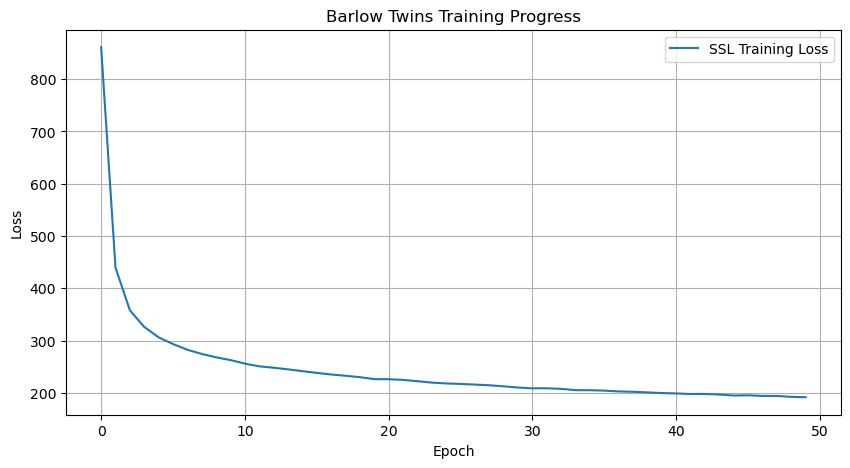

BarlowTwins(
  (backbone): ResNet15(
    (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [36]:
train_ssl(ssl_model, ssl_loader, epochs=50)

In [37]:
# Fine-tuning
ft_dataset = LabelledDataset('../Dataset_Specific_labelled_full_only_for_2i.h5', ft_transform)
train_size = int(0.8*len(ft_dataset))
train_set, test_set = random_split(ft_dataset, [train_size, len(ft_dataset)-train_size])

In [38]:
class FineTuneModel(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        # Freeze backbone initially
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        # Add classification and regression heads
        self.classifier = nn.Linear(512, num_classes)
        self.regressor = nn.Linear(512, 1)
        
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features), self.regressor(features)

In [39]:
def create_loaders(dataset, val_ratio=0.1):
    # Split into train and validation
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(
        train_set,
        batch_size=64,
        shuffle=True,
        num_workers=8,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_set,
        batch_size=64,
        num_workers=8,
        pin_memory=True
    )
    
    return train_loader, val_loader

In [40]:
def create_ft_model(pretrained=True):
    backbone = ResNet15()
    if pretrained:
        # Load pretrained weights
        backbone.load_state_dict(torch.load('./best_ssl.pth'))
    
    # Get number of classes from dataset
    labelled_dataset = LabelledDataset('../Dataset_Specific_labelled_full_only_for_2i.h5', ft_transform)
    num_classes = len(torch.unique(torch.tensor([label for _, label, _ in labelled_dataset])))
    
    return FineTuneModel(backbone, num_classes).to(device)

In [41]:
ft_model = create_ft_model(pretrained=True)
scratch_model = create_ft_model(pretrained=False)

# 3. Create datasets
train_set = LabelledDataset('../Dataset_Specific_labelled_full_only_for_2i.h5', ft_transform)

# 4. Train models
print("Fine-tuning pretrained model:")
train_ft(ft_model, *create_loaders(train_set), epochs=100)

print("\nTraining from scratch:")
train_ft(scratch_model, *create_loaders(train_set), epochs=100)

Fine-tuning pretrained model:

Epoch  | Train Loss | Val Loss   | Improv%  | Status       | LR        
----------------------------------------------------------------------


001/100 | 43.15      | 43.41      |   +inf% | ✔ Improved   | 1.3e-05


002/100 | 43.09      | 43.34      |   +0.2% | ✖ (1/5)      | 1.5e-05


003/100 | 43.03      | 43.26      |   +0.4% | ✖ (2/5)      | 1.9e-05


004/100 | 42.93      | 43.16      |   +0.6% | ✖ (3/5)      | 2.4e-05


005/100 | 42.81      | 43.03      |   +0.9% | ✖ (4/5)      | 3.1e-05


006/100 | 42.66      | 42.86      |   +1.3% | ✔ Improved   | 4.0e-05


007/100 | 42.48      | 42.66      |   +0.5% | ✖ (1/5)      | 4.9e-05


008/100 | 42.27      | 42.42      |   +1.0% | ✔ Improved   | 6.0e-05


009/100 | 42.00      | 42.12      |   +0.7% | ✖ (1/5)      | 7.1e-05


010/100 | 41.69      | 41.78      |   +1.5% | ✔ Improved   | 8.4e-05


011/100 | 41.33      | 41.38      |   +1.0% | ✖ (1/5)      | 9.7e-05


012/100 | 40.90      | 40.93      |   +2.0% | ✔ Improved   | 1.1e-04


013/100 | 40.41      | 40.38      |   +1.3% | ✔ Improved   | 1.3e-04


014/100 | 39.87      | 39.81      |   +1.4% | ✔ Improved   | 1.4e-04


015/100 | 39.25      | 39.16      |   +1.6% | ✔ Improved   | 1.6e-04


016/100 | 38.58      | 38.42      |   +1.9% | ✔ Improved   | 1.7e-04


017/100 | 37.84      | 37.62      |   +2.1% | ✔ Improved   | 1.9e-04


018/100 | 37.03      | 36.70      |   +2.5% | ✔ Improved   | 2.0e-04


019/100 | 36.15      | 35.86      |   +2.3% | ✔ Improved   | 2.1e-04


020/100 | 35.21      | 34.87      |   +2.8% | ✔ Improved   | 2.3e-04


021/100 | 34.24      | 33.78      |   +3.1% | ✔ Improved   | 2.4e-04


022/100 | 33.20      | 32.72      |   +3.1% | ✔ Improved   | 2.5e-04


023/100 | 32.11      | 31.60      |   +3.4% | ✔ Improved   | 2.6e-04


024/100 | 30.99      | 30.41      |   +3.8% | ✔ Improved   | 2.7e-04


025/100 | 29.83      | 29.22      |   +3.9% | ✔ Improved   | 2.8e-04


026/100 | 28.67      | 27.95      |   +4.3% | ✔ Improved   | 2.9e-04


027/100 | 27.48      | 26.92      |   +3.7% | ✔ Improved   | 2.9e-04


028/100 | 26.36      | 25.63      |   +4.8% | ✔ Improved   | 3.0e-04


029/100 | 25.25      | 24.54      |   +4.3% | ✔ Improved   | 3.0e-04


030/100 | 24.16      | 23.42      |   +4.5% | ✔ Improved   | 3.0e-04


031/100 | 23.10      | 22.51      |   +3.9% | ✔ Improved   | 3.0e-04


032/100 | 22.14      | 21.60      |   +4.1% | ✔ Improved   | 3.0e-04


033/100 | 21.22      | 20.62      |   +4.5% | ✔ Improved   | 3.0e-04


034/100 | 20.41      | 19.96      |   +3.2% | ✔ Improved   | 3.0e-04


035/100 | 19.63      | 19.06      |   +4.5% | ✔ Improved   | 3.0e-04


036/100 | 18.89      | 18.35      |   +3.7% | ✔ Improved   | 2.9e-04


037/100 | 18.23      | 17.68      |   +3.6% | ✔ Improved   | 2.9e-04


038/100 | 17.62      | 17.27      |   +2.4% | ✔ Improved   | 2.9e-04


039/100 | 17.12      | 16.70      |   +3.3% | ✔ Improved   | 2.9e-04


040/100 | 16.64      | 16.39      |   +1.8% | ✔ Improved   | 2.9e-04


041/100 | 16.22      | 15.80      |   +3.6% | ✔ Improved   | 2.8e-04


042/100 | 15.82      | 15.49      |   +2.0% | ✔ Improved   | 2.8e-04


043/100 | 15.45      | 15.24      |   +1.6% | ✔ Improved   | 2.8e-04


044/100 | 15.17      | 14.84      |   +2.6% | ✔ Improved   | 2.7e-04


045/100 | 14.91      | 14.67      |   +1.1% | ✔ Improved   | 2.7e-04


046/100 | 14.64      | 14.48      |   +1.3% | ✔ Improved   | 2.6e-04


047/100 | 14.44      | 14.24      |   +1.7% | ✔ Improved   | 2.6e-04


048/100 | 14.25      | 14.05      |   +1.3% | ✔ Improved   | 2.5e-04


049/100 | 14.04      | 13.93      |   +0.9% | ✖ (1/5)      | 2.5e-04


050/100 | 13.94      | 13.77      |   +2.0% | ✔ Improved   | 2.4e-04


051/100 | 13.78      | 13.64      |   +1.0% | ✖ (1/5)      | 2.4e-04


052/100 | 13.67      | 13.54      |   +1.7% | ✔ Improved   | 2.3e-04


053/100 | 13.57      | 13.37      |   +1.3% | ✔ Improved   | 2.3e-04


054/100 | 13.47      | 13.34      |   +0.2% | ✖ (1/5)      | 2.2e-04


055/100 | 13.32      | 13.23      |   +1.0% | ✔ Improved   | 2.2e-04


056/100 | 13.23      | 13.15      |   +0.6% | ✖ (1/5)      | 2.1e-04


057/100 | 13.22      | 13.14      |   +0.7% | ✖ (2/5)      | 2.0e-04


058/100 | 13.12      | 13.00      |   +1.7% | ✔ Improved   | 2.0e-04


059/100 | 13.09      | 12.92      |   +0.7% | ✖ (1/5)      | 1.9e-04


060/100 | 12.98      | 12.85      |   +1.2% | ✔ Improved   | 1.8e-04


061/100 | 12.92      | 12.76      |   +0.7% | ✖ (1/5)      | 1.8e-04


062/100 | 12.85      | 12.79      |   +0.4% | ✖ (2/5)      | 1.7e-04


063/100 | 12.82      | 12.67      |   +1.4% | ✔ Improved   | 1.6e-04


064/100 | 12.79      | 12.71      |   -0.3% | ✖ (1/5)      | 1.6e-04


065/100 | 12.76      | 12.68      |   -0.1% | ✖ (2/5)      | 1.5e-04


066/100 | 12.70      | 12.61      |   +0.5% | ✖ (3/5)      | 1.4e-04


067/100 | 12.66      | 12.54      |   +1.0% | ✔ Improved   | 1.4e-04


068/100 | 12.60      | 12.60      |   -0.5% | ✖ (1/5)      | 1.3e-04


069/100 | 12.63      | 12.51      |   +0.2% | ✖ (2/5)      | 1.2e-04


070/100 | 12.58      | 12.51      |   +0.2% | ✖ (3/5)      | 1.2e-04


071/100 | 12.56      | 12.50      |   +0.3% | ✖ (4/5)      | 1.1e-04


072/100 | 12.48      | 12.50      |   +0.3% | ✖ (5/5)      | 1.0e-04

Early stopping at epoch 72

Training from scratch:

Epoch  | Train Loss | Val Loss   | Improv%  | Status       | LR        
----------------------------------------------------------------------


001/100 | 43.17      | 42.70      |   +inf% | ✔ Improved   | 1.3e-05


002/100 | 43.04      | 42.56      |   +0.3% | ✖ (1/5)      | 1.5e-05


003/100 | 42.87      | 42.38      |   +0.7% | ✖ (2/5)      | 1.9e-05


004/100 | 42.66      | 42.15      |   +1.3% | ✔ Improved   | 2.4e-05


005/100 | 42.42      | 41.86      |   +0.7% | ✖ (1/5)      | 3.1e-05


006/100 | 42.09      | 41.50      |   +1.6% | ✔ Improved   | 4.0e-05


007/100 | 41.68      | 41.04      |   +1.1% | ✔ Improved   | 4.9e-05


008/100 | 41.16      | 40.49      |   +1.3% | ✔ Improved   | 6.0e-05


009/100 | 40.54      | 39.79      |   +1.7% | ✔ Improved   | 7.1e-05


010/100 | 39.80      | 39.01      |   +2.0% | ✔ Improved   | 8.4e-05


011/100 | 38.93      | 38.06      |   +2.4% | ✔ Improved   | 9.7e-05


012/100 | 37.92      | 37.00      |   +2.8% | ✔ Improved   | 1.1e-04


013/100 | 36.76      | 35.75      |   +3.4% | ✔ Improved   | 1.3e-04


014/100 | 35.47      | 34.35      |   +3.9% | ✔ Improved   | 1.4e-04


015/100 | 34.02      | 32.84      |   +4.4% | ✔ Improved   | 1.6e-04


016/100 | 32.41      | 31.16      |   +5.1% | ✔ Improved   | 1.7e-04


017/100 | 30.62      | 29.32      |   +5.9% | ✔ Improved   | 1.9e-04


018/100 | 28.72      | 27.30      |   +6.9% | ✔ Improved   | 2.0e-04


019/100 | 26.67      | 25.20      |   +7.7% | ✔ Improved   | 2.1e-04


020/100 | 24.54      | 23.03      |   +8.6% | ✔ Improved   | 2.3e-04


021/100 | 22.39      | 20.98      |   +8.9% | ✔ Improved   | 2.4e-04


022/100 | 20.32      | 18.96      |   +9.6% | ✔ Improved   | 2.5e-04


023/100 | 18.45      | 17.20      |   +9.3% | ✔ Improved   | 2.6e-04


024/100 | 16.84      | 15.75      |   +8.4% | ✔ Improved   | 2.7e-04


025/100 | 15.56      | 14.69      |   +6.7% | ✔ Improved   | 2.8e-04


026/100 | 14.57      | 13.80      |   +6.0% | ✔ Improved   | 2.9e-04


027/100 | 13.83      | 13.21      |   +4.3% | ✔ Improved   | 2.9e-04


028/100 | 13.29      | 12.74      |   +3.6% | ✔ Improved   | 3.0e-04


029/100 | 12.93      | 12.40      |   +2.7% | ✔ Improved   | 3.0e-04


030/100 | 12.65      | 12.18      |   +1.8% | ✔ Improved   | 3.0e-04


031/100 | 12.46      | 12.03      |   +1.2% | ✔ Improved   | 3.0e-04


032/100 | 12.35      | 11.91      |   +1.0% | ✔ Improved   | 3.0e-04


033/100 | 12.27      | 11.81      |   +0.8% | ✖ (1/5)      | 3.0e-04


034/100 | 12.20      | 11.77      |   +1.1% | ✔ Improved   | 3.0e-04


035/100 | 12.15      | 11.73      |   +0.3% | ✖ (1/5)      | 3.0e-04


036/100 | 12.14      | 11.71      |   +0.5% | ✖ (2/5)      | 2.9e-04


037/100 | 12.12      | 11.69      |   +0.7% | ✖ (3/5)      | 2.9e-04


038/100 | 12.10      | 11.68      |   +0.7% | ✖ (4/5)      | 2.9e-04


039/100 | 12.09      | 11.68      |   +0.8% | ✖ (5/5)      | 2.9e-04

Early stopping at epoch 39


FineTuneModel(
  (backbone): ResNet15(
    (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [46]:
torch.save(scratch_model.state_dict(), 'best_scratch.pth')

In [42]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_targets = []
    all_reg_preds = []
    
    with torch.no_grad():
        for x, y, t in loader:
            x = x.to(device)
            logits, preds = model(x)
            
            # Store classification and regression results
            all_preds.extend(logits.argmax(1).cpu().numpy())
            all_labels.extend(y.numpy())
            all_targets.extend(t.numpy())
            all_reg_preds.extend(preds.squeeze().cpu().numpy())
    
    # Classification metrics
    acc = (np.array(all_preds) == np.array(all_labels)).mean()
    
    # Regression metrics
    rmse = np.sqrt(mean_squared_error(all_targets, all_reg_preds))
    
    # Generate plots
    plt.figure(figsize=(12,5))
    
    # Confusion matrix
    plt.subplot(1,2,1)
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    
    # Regression scatter plot
    plt.subplot(1,2,2)
    plt.scatter(all_targets, all_reg_preds, alpha=0.3)
    plt.plot([min(all_targets), max(all_targets)], 
             [min(all_targets), max(all_targets)], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'Regression (RMSE: {rmse:.4f})')
    
    plt.tight_layout()
    plt.savefig('model_evaluation.png')
    plt.close()
    
    return acc, rmse


Evaluating models:
Pretrained Model:
Accuracy: 0.7535, RMSE: 48.5507

Scratch Model:
Accuracy: 0.7080, RMSE: 45.6150


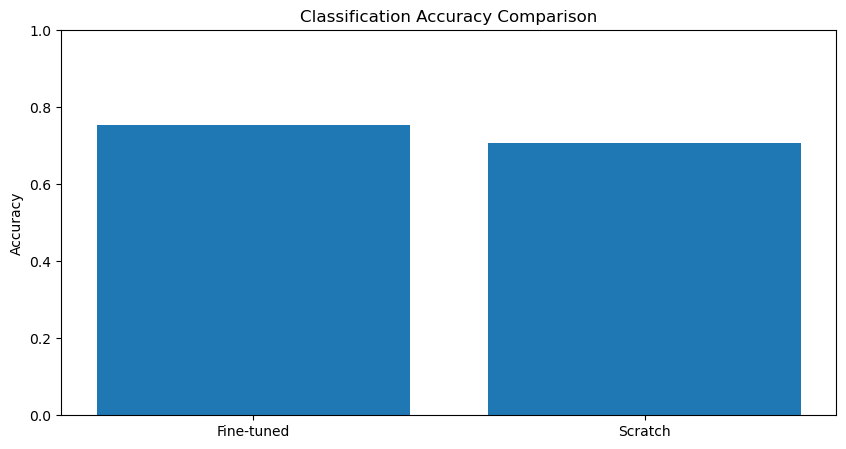

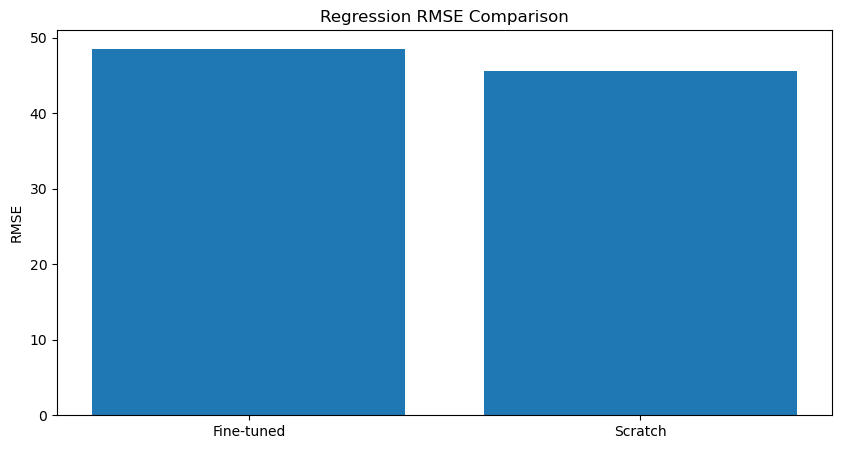

In [43]:
print("\nEvaluating models:")
print("Pretrained Model:")
ft_acc, ft_rmse = evaluate_model(ft_model, DataLoader(test_set, batch_size=64))
print(f"Accuracy: {ft_acc:.4f}, RMSE: {ft_rmse:.4f}")

print("\nScratch Model:")
scratch_acc, scratch_rmse = evaluate_model(scratch_model, DataLoader(test_set, batch_size=64))
print(f"Accuracy: {scratch_acc:.4f}, RMSE: {scratch_rmse:.4f}")

# Generate comparison plots
plt.figure(figsize=(10,5))
plt.bar([0, 1], [ft_acc, scratch_acc], tick_label=['Fine-tuned', 'Scratch'])
plt.title('Classification Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.savefig('./accuracy_comparison.png')

plt.figure(figsize=(10,5))
plt.bar([0, 1], [ft_rmse, scratch_rmse], tick_label=['Fine-tuned', 'Scratch'])
plt.title('Regression RMSE Comparison')
plt.ylabel('RMSE')
plt.savefig('./rmse_comparison.png')

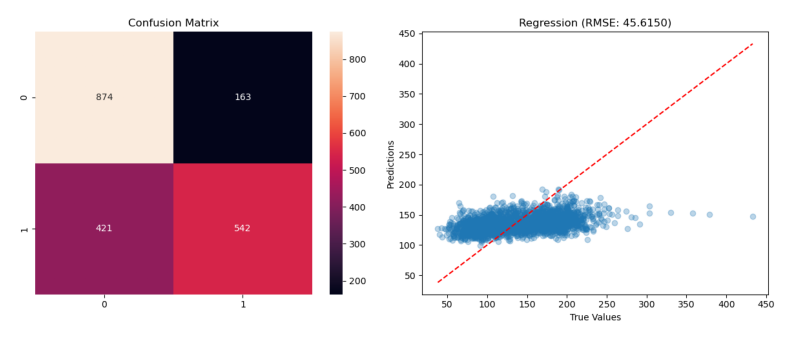

In [44]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('./model_evaluation.png')

plt.figure(figsize=(10,5))
plt.imshow(img)
plt.axis('off')
plt.show()

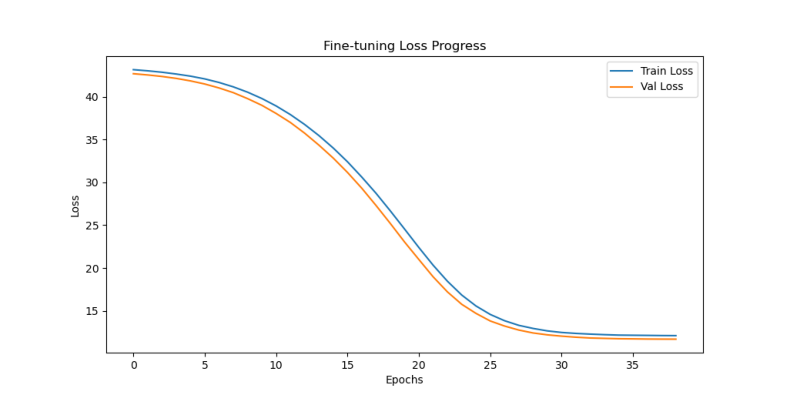

In [45]:
img = mpimg.imread('./ft_final_progress.png')

plt.figure(figsize=(10,5))
plt.imshow(img)
plt.axis('off')
plt.show()

In [53]:
def print_model_layers(model, model_name):
    print(f"\n{'-'*40}")
    print(f"{model_name} Architecture:")
    print(f"{'-'*40}")
    for name, layer in model.named_modules():
        if not list(layer.children()):
            print(f"{name}: {layer.__class__.__name__}")
    print(f"{'-'*40}\n")

# First determine number of classes from your dataset
labelled_dataset = LabelledDataset('../Dataset_Specific_labelled_full_only_for_2i.h5', ft_transform)
num_classes = len(torch.unique(torch.tensor([label for _, label, _ in labelled_dataset])))

# Load and print SSL pretrained backbone
ssl_backbone = ResNet15()
ssl_backbone.load_state_dict(torch.load('./best_ssl.pth'))
print_model_layers(ssl_backbone, "SSL Pretrained Backbone")

# Load and print fine-tuned model
ft_model = FineTuneModel(ResNet15(), num_classes=num_classes)
ft_model.load_state_dict(torch.load('./best_ft.pth')) 
print_model_layers(ft_model, "Fine-Tuned Model")

# Load and print scratch model
scratch_model = FineTuneModel(ResNet15(), num_classes=num_classes)
scratch_model.load_state_dict(torch.load('./best_scratch.pth'))
print_model_layers(scratch_model, "Scratch Model")


----------------------------------------
SSL Pretrained Backbone Architecture:
----------------------------------------
conv1: Conv2d
bn1: BatchNorm2d
relu: ReLU
maxpool: MaxPool2d
layer1.0.conv1: Conv2d
layer1.0.bn1: BatchNorm2d
layer1.0.relu: ReLU
layer1.0.conv2: Conv2d
layer1.0.bn2: BatchNorm2d
layer1.1.conv1: Conv2d
layer1.1.bn1: BatchNorm2d
layer1.1.relu: ReLU
layer1.1.conv2: Conv2d
layer1.1.bn2: BatchNorm2d
layer2.0.conv1: Conv2d
layer2.0.bn1: BatchNorm2d
layer2.0.relu: ReLU
layer2.0.conv2: Conv2d
layer2.0.bn2: BatchNorm2d
layer2.0.downsample.0: Conv2d
layer2.0.downsample.1: BatchNorm2d
layer2.1.conv1: Conv2d
layer2.1.bn1: BatchNorm2d
layer2.1.relu: ReLU
layer2.1.conv2: Conv2d
layer2.1.bn2: BatchNorm2d
layer3.0.conv1: Conv2d
layer3.0.bn1: BatchNorm2d
layer3.0.relu: ReLU
layer3.0.conv2: Conv2d
layer3.0.bn2: BatchNorm2d
layer3.0.downsample.0: Conv2d
layer3.0.downsample.1: BatchNorm2d
layer4.0.conv1: Conv2d
layer4.0.bn1: BatchNorm2d
layer4.0.relu: ReLU
layer4.0.conv2: Conv2d
layer4

In [54]:
# For loading the models:
def load_pretrained():
    backbone = ResNet15()
    backbone.load_state_dict(torch.load('./best_ssl.pth'))
    return backbone

def load_finetuned(num_classes):
    model = FineTuneModel(ResNet15(), num_classes)
    model.load_state_dict(torch.load('./best_ft.pth'))
    return model

def load_scratch(num_classes):
    model = FineTuneModel(ResNet15(), num_classes)
    model.load_state_dict(torch.load('./best_scratch.pth'))
    return model